In [35]:
from pyincore import FragilityService, DataService, HazardService, ComputeDamage
from pyincore import PlotUtil
from pyincore import InventoryDataset
import pprint
pp = pprint.PrettyPrinter(indent=4)

Getting a Fragility Set from the service

Print Fragility Set obtained from fragility service

In [21]:
metadata = DataService.get_dataset_metadata('http://localhost:8080', '59f3617de1b2b828641a012a')
metadata

{   'contributors': [],
    'creator': None,
    'date': '2017-10-27T11:40:29-0500',
    'deleted': False,
    'description': '',
    'fileDescriptors': [   {   'dataURL': 'file:/C:/Rest/59/f3/59f3617de1b2b828641a012c/Hospitals1228337472406.mvz',
                               'deleted': False,
                               'filename': 'Hospitals1228337472406.mvz',
                               'id': '59f3617de1b2b828641a012c',
                               'md5sum': 'b14425c3394e923709d7994f433af48e',
                               'mimeType': 'application/octet-stream',
                               'size': 1554},
                           {   'dataURL': 'file:/C:/Rest/59/f3/59f3617de1b2b828641a012f/all_bldgs_ver5_WGS1984.dbf',
                               'deleted': False,
                               'filename': 'all_bldgs_ver5_WGS1984.dbf',
                               'id': '59f3617de1b2b828641a012f',
                               'md5sum': '7ea0a4c769ca254a6b4821f2e7

In [22]:
localfile = DataService.get_dataset('http://localhost:8080', '59f3617de1b2b828641a012a')
hospital = InventoryDataset(localfile)

It already exsists; no unzip


In [23]:
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_features(hospital.inventory_set)
#hospital= gpd.read_file('data/Hospitals1228337472406', layer='all_bldgs_ver5_WGS1984')

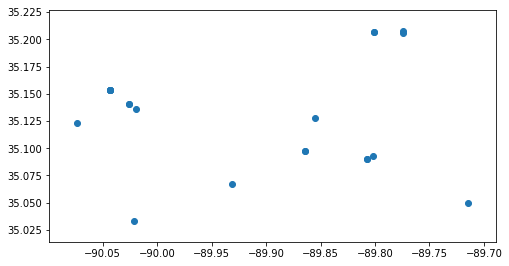

In [24]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 8, 6
gdf.plot()

In [25]:
gdf.head()

,IMPUTED,Soil,a_stories,appr_bldg,b_stories,bldg_id,broad_occ,bsmt_type,cont_val,dgn_lvl,...,parid,parid_card,repl_cst,sq_foot,str_cst,str_prob,str_typ2,struct_typ,tract_id,year_built
0,F,Upland,1,163315,0,018060 00010_2_1,Health Care,NONE,2042598,Moderate - Code,...,018060 00010,018060 00010_2,1361732,6062,186557,1.00000,C1L,C1,47157003800,1978
1,F,Upland,3,524485,1,018060 00010_1_1,Health Care,COMMERCIAL BSMT,6363539,Pre - Code,...,018060 00010,018060 00010_1,4242359,19468,547264,1.00000,C1L,C1,47157003800,1925
2,F,Upland,13,49457042,1,016001 00001C_1_1,Health Care,COMMERCIAL BSMT,251974698,Pre - Code,...,016001 00001C,016001 00001C_1,167983132,910583,21669824,0.95161,S1H,S1,47157003600,1924
3,F,Lowland,3,367311,2,012008 00012_1_1,Health Care,COMMERCIAL BSMT,21677039,Pre - Code,...,012008 00012,012008 00012_1,14451359,65112,1864225,0.88908,URML,URM,47157005200,1910
4,F,Upland,2,1027399,0,001041 00001C_8_1,Health Care,NONE,10456153,Moderate - Code,...,001041 00001C,001041 00001C_8,6970769,32094,954995,0.64700,S1L,S1,47157002200,1991


In [26]:
import folium

m = folium.Map()
folium.GeoJson(gdf.to_json(), name='hospital').add_to(m)
ext = gdf.total_bounds
m.fit_bounds([[ext[1], ext[0]], [ext[3], ext[2]]])
m

In [27]:
building = next(iter(hospital.inventory_set))

{   'authors': ['Amr S. Elnashai', 'Seong-Hoon Jeong', 'Joshua S. Steelman'],
    'demandType': 'PGA',
    'demandUnits': 'g',
    'description': 'Low-Rise Concrete Moment Frame',
    'fragilityCurves': [   {   'beta': 0.414,
                               'className': 'edu.illinois.ncsa.incore.service.fragility.models.PeriodStandardFragilityCurve',
                               'curveType': 'LogNormal',
                               'description': 'Moderate',
                               'median': -1.597,
                               'periodEqnType': 1,
                               'periodParam0': 0.4,
                               'periodParam1': 0.0,
                               'periodParam2': 0.0},
                           {   'beta': 0.414,
                               'className': 'edu.illinois.ncsa.incore.service.fragility.models.PeriodStandardFragilityCurve',
                               'curveType': 'LogNormal',
                               'description': '

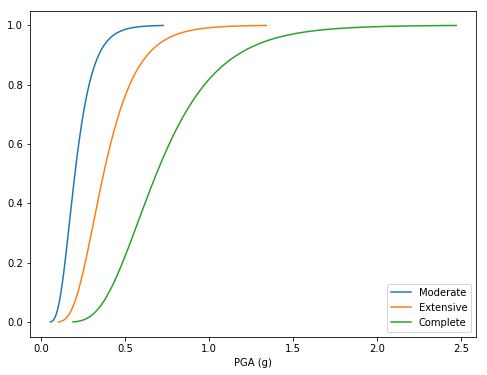

In [29]:
fragility_set = FragilityService.map_fragility('http://localhost:8080', building, "Non-Retrofit Fragility ID Code")
pp.pprint(fragility_set)
for curve in fragility_set['fragilityCurves']:
    x,y = PlotUtil.get_x_y(curve['curveType'],curve['median'],curve['beta'])
    plt.plot(x,y, label=curve['description'])
plt.xlabel(fragility_set['demandType']+" ("+fragility_set['demandUnits']+")")
plt.legend()
plt.show()

In [31]:
latlon = building['geometry']['coordinates']
pp.pprint(latlon)

(-90.02584943848801, 35.140197417765144)


In [33]:
haz_val = HazardService.get_hazard_value("http://localhost:8080", "59f8e10004c01e79c4a67a88", "PGA", "g", latlon[1], latlon[0])
haz_val

0.30999643014594325

In [37]:
damage = ComputeDamage.calculate_damage_json2(fragility_set, haz_val)
damage

OrderedDict([('Moderate', 0.84814634694098445),
             ('Extensive', 0.32731851169389337),
             ('Complete', 0.027229030747067989)])